In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import h5py
import numpy as np
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super(UNet, self).__init__()

        # Encoding path (Downsampling)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck (Center of the network)
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoding path (Upsampling)
        self.decoder4 = self.deconv_block(1024, 512)
        self.decoder3 = self.deconv_block(512, 256)
        self.decoder2 = self.deconv_block(256, 128)
        self.decoder1 = self.deconv_block(128, 64)
        
        # Output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        """
        A convolutional block with two Conv2D layers, followed by ReLU activation and BatchNorm.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def deconv_block(self, in_channels, out_channels):
        """
        A transposed convolutional block to upsample the features.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Decoding path
        dec4 = self.decoder4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)  # Concatenate skip connection
        dec4 = self.conv_block(dec4.size(1), 512)(dec4)  # Apply a conv block on concatenated features
        
        dec3 = self.decoder3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv_block(dec3.size(1), 256)(dec3)
        
        dec2 = self.decoder2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv_block(dec2.size(1), 128)(dec2)
        
        dec1 = self.decoder1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv_block(dec1.size(1), 64)(dec1)
        
        # Output layer
        out = self.output(dec1)
        return out

def train_model(dataloader, model, criterion, optimizer, num_epochs=10):
    
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, masks in dataloader:
            # Move the data to the same device as the model (GPU/CPU)
            images, masks = images.to(device), masks.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, masks)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track the loss
            running_loss += loss.item()
        
        # Print statistics after each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')
    
    print("Training completed.")

class UNetDataset(Dataset):
    
    def __init__(self, train_files, data_dir, image_dim=(128, 128)):
        """
        Dataset for loading images and masks from HDF5 files.

        Parameters:
        - train_files: List of file names of the training HDF5 files.
        - data_dir: Directory where the HDF5 files are stored.
        - image_dim: Desired dimensions of the output images and masks (height, width).
        """
        self.train_files = train_files
        self.data_dir = data_dir
        self.image_dim = image_dim
    
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.train_files)
    
    def __getitem__(self, idx):
        """
        Load a single sample from the HDF5 file, apply transformations, and return the image and mask.
        
        Parameters:
        - idx: Index of the sample to be loaded.
        
        Returns:
        - image: Tensor of shape (C, H, W) for the image.
        - mask: Tensor of shape (1, H, W) for the mask.
        """
        file_path = os.path.join(self.data_dir, self.train_files[idx])
        with h5py.File(file_path, 'r') as hf:
            # Check for the correct keys
            if 'image' in hf.keys() and 'mask' in hf.keys():
                image = hf['image'][:]  # Expected shape: (H, W, 4)
                mask = hf['mask'][:]    # Expected shape: (H, W) or (H, W, C)
            else:
                raise KeyError(f"Unexpected keys in {self.train_files[idx]}: {list(hf.keys())}")

            # Resize images if necessary
            if image.shape[:2] != self.image_dim:
                image = resize(
                    image, 
                    (*self.image_dim, image.shape[2]), 
                    preserve_range=True, 
                    anti_aliasing=True
                )

            if mask.shape != self.image_dim:
                # Use nearest-neighbor interpolation for masks to preserve labels
                mask = resize(
                    mask, 
                    self.image_dim, 
                    preserve_range=True, 
                    order=0, 
                    anti_aliasing=False
                )

            # Normalize the image
            image_max = np.max(image)
            if image_max > 0:
                image = image.astype('float32') / image_max
            else:
                image = image.astype('float32')

            # Normalize the mask
            mask_max = np.max(mask)
            if mask_max > 0:
                mask = mask.astype('float32') / mask_max
            else:
                mask = mask.astype('float32')  # All zeros

            # Convert to tensor and reorder channels to (C, H, W)
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)  # C, H, W
                
            mask = torch.tensor(mask.transpose(2, 0, 1), dtype=torch.float32)  # C, H, W

        return image, mask

In [8]:
# Define the model
model = UNet(in_channels=4, out_channels=3)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Loss function (Binary Cross-Entropy Loss for binary segmentation)
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [13]:
# Define the data directory (adjust this path if necessary)
data_dir = 'BraTS2020_training_data/content/small_data/'

# Get list of .h5 files
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Ensure that there are .h5 files in the directory
if not h5_files:
    raise FileNotFoundError(f"No .h5 files found in the directory: {data_dir}")

# Split into training and validation sets
train_files, val_files = train_test_split(h5_files, test_size=0.2, random_state=42)

print(f"Total samples: {len(h5_files)}")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Parameters
batch_size = 8  # Adjust based on GPU memory

image_dim = (128, 128)  # Adjust based on your image dimensions

shuffle = True

dataset = UNetDataset(train_files, data_dir, image_dim)
    
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_model(dataloader, model, criterion, optimizer, num_epochs=10)

# # Loop through the data
# for images, masks in dataloader:
#     print(images.shape)  # Should be (batch_size, 4, 128, 128)
#     print(masks.shape)   # Should be (batch_size, 1, 128, 128)

# X_train, y_train = load_data(train_files, data_dir, image_dim=(128, 128))

# X_val, y_val = load_data(val_files, data_dir, image_dim=(128, 128))

Total samples: 62
Training samples: 49
Validation samples: 13
Epoch [1/10], Loss: 0.7138
Epoch [2/10], Loss: 0.7152
Epoch [3/10], Loss: 0.7128
Epoch [4/10], Loss: 0.7120
Epoch [5/10], Loss: 0.7122
Epoch [6/10], Loss: 0.7138
Epoch [7/10], Loss: 0.7105
Epoch [8/10], Loss: 0.7096
Epoch [9/10], Loss: 0.7093
Epoch [10/10], Loss: 0.7098
Training completed.


In [10]:
def show_single_h5_file(filename):

    # Load the image and mask from the HDF5 file
    with h5py.File(filename, 'r') as h5_file:
        image = h5_file["image"][:]
        mask = h5_file["mask"][:]
    
    # --- Figure 1: Image with 4 channels ---
    fig1, axs1 = plt.subplots(2, 2, figsize=(10, 10))
    
    Channel = ["T1", "T1_weighted", "T2_weighted", "T2_FLAIR"]
    
    # Plot each channel of the image in separate subplots
    for i in range(4):
        axs1[i//2, i%2].imshow(image[..., i])
        axs1[i//2, i%2].set_title(f"Channel: {Channel[i]}")
        axs1[i//2, i%2].axis('off')
    
    fig1.suptitle('Fig.1: Image with 4 Channels', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title so it fits
    plt.show()
    
    # --- Figure 2: Mask with 3 channels ---
    fig2, axs2 = plt.subplots(1, 3, figsize=(10, 4))

    Channel = ["NCR/NET", "ED","ET"]
    
    # Plot each channel of the mask in separate subplots
    for i in range(3):
        axs2[i].imshow(mask[..., i])
        axs2[i].set_title(f"Channel:{Channel[i]}")
        axs2[i].axis('off')
    
    fig2.suptitle('Fig.2: Mask with 3 Channels', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title so it fits
    plt.show()

In [11]:
# # Assuming train_files and data_dir are defined
# filename = os.path.join(data_dir, train_files[-1])

# show_single_h5_file(filename)

In [12]:
def get_all_slices(volume_index, slice_range, data_dir):
    """
    Generates filenames for the MRI volume and slice range.

    Parameters:
    - volume_index: Index of the volume (e.g., 1 for 'volume_1', 2 for 'volume_2', etc.)
    - slice_range: List of slice indices to load (e.g., [0, 1, 2, ..., 155])
    - data_dir: Directory containing the HDF5 files.

    Returns:
    - filenames: List of filenames corresponding to the specified volume and slice range.
    """
    image_list = []
    mask_list=[]
    for slice_idx in slice_range:
        # Construct the filename
        filename = os.path.join(data_dir, f"volume_{volume_index}_slice_{slice_idx}.h5")
        
        # Check if the file exists before adding to the list
        if os.path.exists(filename):
            with h5py.File(filename, 'r') as h5_file:
                image_list.append(h5_file["image"][:])
                mask_list.append(h5_file["mask"][:])
        else:
            print(f"File {filename} does not exist.")
    
    return np.transpose(np.array(image_list), (1, 2, 0, 3)), np.transpose(np.array(mask_list), (1, 2, 0, 3))

# Example usage:
volume_index = 100  # Volume number (e.g., 'volume_1')
slice_range = range(0, 100)  # List of slices (e.g., slices 0, 1, 2)
data_dir = "BraTS2020_training_data/content/data/"  # Path to your data directory
# Get the filenames for the specified volume and slices
image_list, mask_list = get_all_slices(volume_index, slice_range, data_dir)

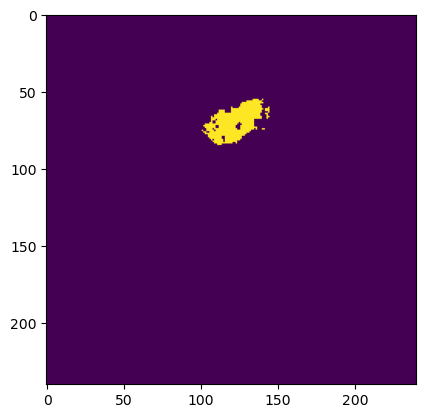

In [115]:
plt.imshow(mask_list[:,:,50,0])